In [39]:
#@title import packages

import albumentations as A
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision
import skimage

from glob import glob
from lsd.train import local_shape_descriptor
from scipy.ndimage import binary_erosion
from skimage.measure import label
from skimage.io import imread
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.auto import tqdm


import pandas as pd

In [43]:
# create a torch dataset

class CellDataset(Dataset):
    def __init__(
        self,
        image_dir,
        mask_dir,
        split='train',
        crop_size=None,
        padding_size=8,
        input_type = 'raw',
        output_type = 'labels'):

        self.images = sorted(glob(image_dir))
        self.masks = sorted(glob(mask_dir))

        self.split = split
        self.crop_size = crop_size
        self.padding_size = padding_size

        self.input_type = input_type
        self.output_type = output_type


    def __len__(self):
        return len(self.images)

    # function to erode label boundaries
    def erode(self, labels, iterations, border_value):

        foreground = np.zeros_like(labels, dtype=bool)

        # loop through unique labels
        for label in np.unique(labels):

            # skip background
            if label == 0:
                continue

            # mask to label
            label_mask = labels == label

            # erode labels
            eroded_mask = binary_erosion(
                    label_mask,
                    iterations=iterations,
                    border_value=border_value)

            # get foreground
            foreground = np.logical_or(eroded_mask, foreground)

        # and background...
        background = np.logical_not(foreground)

        # set eroded pixels to zero
        labels[background] = 0

        return labels

    def get_lsds(self, labels):
        labels = self.erode(
            labels,
            iterations=1,
            border_value=1)
        
        lsds = local_shape_descriptor.get_local_shape_descriptors(
                segmentation=labels,
                sigma=(5,)*2,
                voxel_size=(1,)*2)
        
        return lsds.astype(np.float32)

    # takes care of padding
    def get_padding(self, crop_size, padding_size):
    
        # quotient
        q = int(crop_size / padding_size)
    
        if crop_size % padding_size != 0:
            padding = (padding_size * (q + 1))
        else:
            padding = crop_size
    
        return padding
    
    # sample augmentations (see https://albumentations.ai/docs/examples/example_kaggle_salt)
    def augment_data(self, raw, mask, padding):
        
        transform = A.Compose([
            A.RandomCrop(
                width=self.crop_size,
                height=self.crop_size),
            A.PadIfNeeded(
                min_height=padding,
                min_width=padding,
                p=1,
                border_mode=0),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.3),
            A.Transpose(p=0.3),
            A.RandomBrightnessContrast(p=0.3)
        ])

        # i want some labels in the cropped pic
        # at least 10% of the cropped area
        check = 1000
        transformed = {'image': 0, 'mask': np.zeros((1,1,1))}
        area = self.crop_size * self.crop_size

        while np.sum(transformed['mask'] != 0) / area < 0.1 and check > 0:
            transformed = transform(image=raw, mask=mask)

            check -= 1

        if check == 0:
            print('(._.)    no labels in crop')

        raw, mask = transformed['image'], transformed['mask']
        
        return raw, mask

    # normalize raw data between 0 and 1
    def normalize(self, data):
        return (data - np.min(data)) / (np.max(data) - np.min(data)).astype(np.float32)

    def __getitem__(self, idx):

        raw = self.images[idx]
        labels = self.masks[idx]

        raw = imread(raw)
        raw = self.normalize(raw)
        
        # slice first channel, relabel connected components
        labels = label(imread(labels)).astype(np.uint16)


        padding = self.get_padding(self.crop_size, self.padding_size)
        raw, labels = self.augment_data(raw, labels, padding)

        # depending on the model I need different inputs
        if self.input_type == 'raw':
            input = np.expand_dims(raw, axis=0)

        elif self.input_type == 'lsds':
            input = self.get_lsds(labels)

        elif self.input_type == 'raw_lsds':
            input = np.concatenate((np.expand_dims(raw, axis=0), self.get_lsds(labels)), axis=0)
        

        # depending on the model I need different outputs
        if self.output_type == 'labels':
            output = np.expand_dims(labels, axis=0)

        elif self.output_type == 'lsds':
            output = self.get_lsds(labels)

        elif self.output_type == 'boundaries':
            output = skimage.segmentation.find_boundaries(labels)[None]
        


        return input, output


datasets used

In [44]:
input_dataset = '_GFP_max_clahe'
segmentation_dataset = '_CELL_manual'

TypeError: Invalid shape (1, 256, 256) for image data

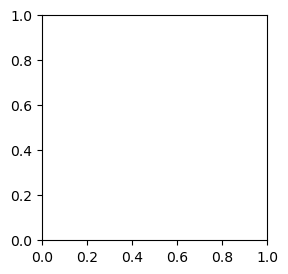

In [ ]:
train_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + segmentation_dataset + '.tif',
    crop_size=256,
    input_type='raw', output_type='boundaries')

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True)

train_iter = iter(train_dataset)


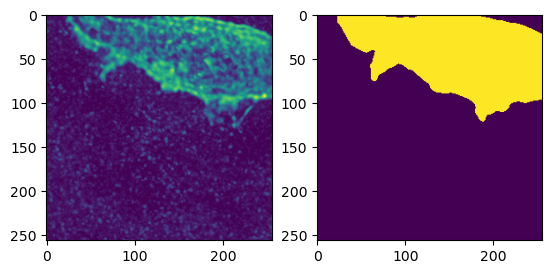